In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Basic Methods for ODEs

## Test case: orbits

We'll use the case of the Earth orbiting the Sun as our test case (we'll assume that the mass of the Earth is insignificant compared to the mass of the Sun).

This is a nice test case for integrating ODEs because we have a lot of intuition for the problem.  If we setup the orbit to be circular, we would expect the integration to keep Earth the same distance from the Sun as it evolves in its orbit.  If we see Earth spiraling inward or outward, then we know that our integration is not very accurate.

Kepler's 3rd law (neglecting the orbiting object's mass) is:

$$ 4\pi^2 a^3 = G M_\star P^2$$

If we work in units of solar masses, astronomical units (AU), and years, then Kepler's third law is

$$a^3 = P^2$$

which implies that Newton's gravitational constant is $G = 4\pi^2$

We will put the Sun at the origin of coordinates.  Then our system of equations is

$$\dot{\bf r} = {\bf v}$$

$$\dot{\bf v} = -\frac{GM_\star {\bf r}}{r^3}$$

where ${\bf r} = (x, y)$ and ${\bf v} = (v_x, v_y)$ 

## Euler's method

The simplest method to advance the solution starts with the first-order difference approximations we found for a derivative:

$$\frac{{\bf r}^{n+1} - {\bf r}^n}{\tau} = {\bf v}^n + \mathcal{O}(\tau)$$

$$\frac{{\bf v}^{n+1} - {\bf v}^n}{\tau} = {\bf a}({\bf r}^n, {\bf v}^n) + \mathcal{O}(\tau)$$

Here, $\tau$ is the timestep we take and we denote the time-level of the state using a subscript,
so $t^n$ is the current time and $t^{n+1} = t^n + \tau$.

Expressing the new state in terms of the old:

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^n + \mathcal{O}(\tau^2)$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^n, {\bf v}^n) + \mathcal{O}(\tau^2)$$

The local error is $O(\tau^2)$, but to evolve to some time $T$, we will take a large number of steps, $N$, $N = T/\tau$, so globally, after evolving to the final time, we will have an error that is $O(\tau)$.  Therefore Euler's method is first-order accurate.

Graphically, for the ODE $\dot{y} = -y$, Euler's method looks like:

![Euler's method](rk2_Euler.png)

We find the slope at $t^n$ and follow it forward for the full $\tau$ to $t^{n+1}$.

Now let's do our orbits.  We need a function that returns the righthand side of the ODEs, so we'll write that first.  It's customary to supply a single vector of inputs and get a single vector of their derivatives, so we'll define

$$ Y = \left ( \begin{array}{c} x \\ y \\ v_x \\ v_y \end{array} \right )$$

In [2]:
G = 4*np.pi**2
M_sun = 1.0

def rhs(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy
    
    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([xdot, ydot, vxdot, vydot])

Many times and ODE solver will just give you the solution at the end of integration.  But we want to make plots, so we want to store the solution along the way.  We will create a special class to hold the solution at each step.

In [3]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])


Now we can write a driver that takes the initial conditions and integrates to a time $T$ using a constant timestep $\tau$.

In [4]:
def euler_orbit(Y0, tau, T):
    
    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Ydot = rhs(t, Y)
        
        # do the Euler update
        Y += tau * Ydot
        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
        

We'll start out on the +y axis and give the Earth a counterclockwise circular velocity.

In [5]:
x0 = 0
y0 = 1
vx0 = -np.sqrt(G*M_sun/y0)
vy0 = 0

Y0 = np.array([x0, y0, vx0, vy0])

Now let's integrate for one period (T = 1, since our time units are years).  We'll our timestep to be 1 month&mdash;let's see how we do with that.

In [6]:
T = 1
tau = T/12.0

orbit = euler_orbit(Y0, tau, 1)

Let's plot the solution.

Text(0, 0.5, 'y [AU]')

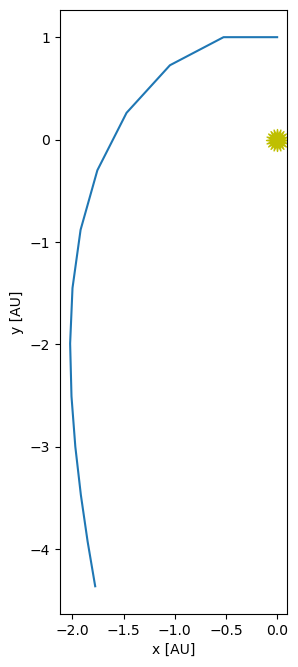

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

# draw the orbit
ax.plot(orbit.x, orbit.y)

ax.set_aspect("equal")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

The solution looks awful.  It should be a circle, and after 1 year, we should be right back at where we started.  Let's look at how we converge with the size of the timestep, $\tau$.

Text(0, 0.5, 'y [AU]')

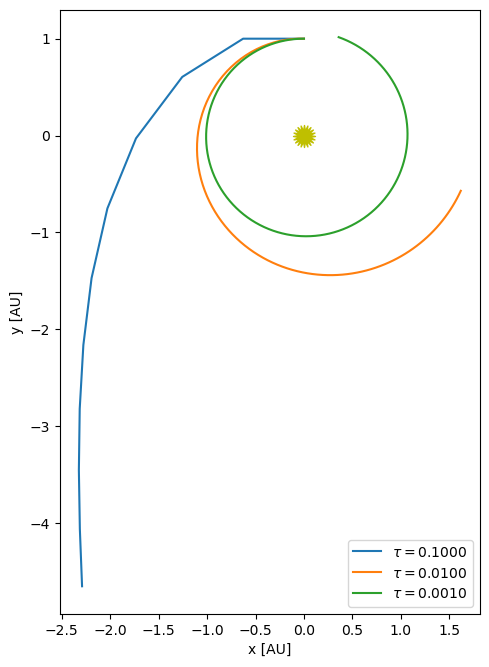

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

taus = [0.1, 0.01, 0.001]

for tau in taus:
    orbit = euler_orbit(Y0, tau, 1)
    
    ax.plot(orbit.x, orbit.y, label=rf"$\tau = {tau:6.4f}$")

ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

Clearly our solution gets better as we reduce the timestep, but we need to reduce it a lot.  At the top we said that the Euler method is globally first-order accurate.  Let's try to confirm that and then let's look at how we can do higher-order integration.

## Measuring convergence

Imagine evolving for a single period and then asking how well did the integrator do.  We need some metric to determine this.  We can imagine a few different measures:

1. compare the current distance to the Sun to the original distance to the Sun

2. compute the distance from the current $(x, y)$ position to the starting position

3. compute the total energy at the end of the integration and compare to the initial total energy.

There are likely many more.  Unlike the integrals we did previously, where the natural error to compute was the difference between the numerical integral and the analytic one, here there is not a single obvious metric.  So we should pick one or more and look for convergence.  Depending on what our goal is, one metric might be more meaningful than another.

Let's define an error function based on metric 1 above

In [9]:
def error(history):
    
    # define the error to be distance from (0, 0) at end compared to start
    R_orig = np.sqrt(history.x[0]**2 + history.y[0]**2)
    R_new = np.sqrt(history.x[-1]**2 + history.y[-1]**2)
    e = np.abs(R_new - R_orig)
    
    return e

Now let's integrate a bunch of orbits, reducing $\tau$ by 2 each time.  Since this is first order accurate, the error should decrease by a factor of 2.

In [10]:
taus = [0.1, 0.05, 0.025, 0.0125, 0.00625]

for tau in taus:
    orbit = euler_orbit(Y0, tau, 1)
    print(error(orbit))

4.186923100574993
2.63132561836189
1.579518716431993
0.8788126438377246
0.45891625361582156


We see that the decrease in the error is essentially 2.  It is certainly not better than first-order accurate.